# Handwritten Digits Recognizer

### Steps

- Load MNIST dataset (handwritten digits) and visualize sample digits
- Write basic preprocessing of dataset: normalize images, split train/test sets.
- Implement first simple feedforward NN
- Train subset (~1-5k images) quick results
- Evaluate accuracy -> even if low
- Upgrade NN to simple CN (1-2 conv layers)
- Train CNN on MNIST -> aim for 95% accuracy
- Log results, plot loss/accuracy curves.
- Finalize CNN -> add droput/batch norm
- Train an ML model (SVM - to compare performance with NN and CNN) 
- save trained model and write simple inference script.
- Optional: create basic CLI to input image and get predicted digits

# Dataset

Content

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. .

Four files are available:

- train-images-idx3-ubyte.gz: training set images (9912422 bytes)
- train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
- t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
- t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)

Goal: To create a CNN that can detect the handwritten digits. In the end I should have a CLI app that I can input an image and output the correct digit.

# First Tasks

- Create reader and plotter for minst dataset
- Visualize the images. 
- Preprocess dataset (Clean, Normalize, etc.)
- Get statistical metrics of dataset and Plot metrics.

IDX format

- Magic Number
- size in dimension 0
- size in dimension 1
- size in dimension 2
- ...
- size in dimension N
- data

magic number is 4 bytes integers with two bytes set as 0 and the other two bytes used to describe:
- basic data type used (3rd byte)
- number of dimensions of the stored array (4th byte)

data types:
- 0x08: unsigned byte 
- 0x09: signed byte 
- 0x0B: short (2 bytes) 
- 0x0C: int (4 bytes) 
- 0x0D: float (4 bytes) 
- 0x0E: double (8 bytes)

4th byte codes the number of dimensions of the vector/matrix:
1 would be for vectors, 2 for two dimension matrices, etc.

Then size of each dimension (4-byte integers, MSB first, big-endian)

data itself is stored in a C array (row-major first) where the index in the last dimension change the fastest



In [13]:
import os
import numpy as np

mnst_dataset = {
    'train_images': 'MNIST_dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
    'train_labels': 'MNIST_dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    'test_images': 'MNIST_dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
    'test_labels': 'MNIST_dataset/t10k-images-idx1-ubyte/t10k-images-idx1-ubyte',
}

train_images_filepath = os.path.join(os.getcwd(),mnst_dataset.get('train_images'))

with open(train_images_filepath,'rb') as file:
    magic_number = file.read(4) #0 0 (data type) (num of dimensions fo stored arrays)
    dimension_1 = int.from_bytes(file.read(4), byteorder='big', signed=False) # 60000
    dimension_2 = int.from_bytes(file.read(4), byteorder='big', signed=False)# 28
    dimension_3 = int.from_bytes(file.read(4), byteorder='big', signed=False)# 28
    data_np = np.frombuffer(file.read(), dtype=np.uint8) #grayscale (8-bit unsigned integer)
data_np = data_np.reshape(dimension_1,dimension_2,dimension_3) #img pixels (img, row, column)

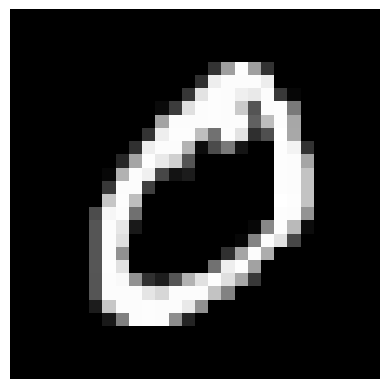

In [14]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(data_np[1],cmap='gray')

In [1]:
from read_mnist import (
    read_imgages_idx,
    read_labels_idx,
    show_image,
    standardize_data,
    split,
    convert_numpy_to_flatten_tensor,
)
from mnist_neural_net import ImageNeuralNet, ModelTraining
import os
import numpy as np
import torch
from torch import nn
import torch.optim as optim

In [2]:
mnst_dataset = {
    'train_images': 'MNIST_dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
    'train_labels': 'MNIST_dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    'test_images': 'MNIST_dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
    'test_labels': 'MNIST_dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte',
}

train_images_filepath = os.path.join(os.getcwd(),mnst_dataset.get('train_images'))
train_labels_filepath = os.path.join(os.getcwd(),mnst_dataset.get('train_labels'))
test_images_filepath = os.path.join(os.getcwd(),mnst_dataset.get('test_images'))
test_labels_filepath = os.path.join(os.getcwd(),mnst_dataset.get('test_labels'))

train_images = read_imgages_idx(train_images_filepath)
train_labels = read_labels_idx(train_labels_filepath)
test_images = read_imgages_idx(test_images_filepath)
test_labels = read_labels_idx(test_labels_filepath)


In [3]:
X_train, X_val, y_train, y_val = split(train_images, train_labels, 0.2)

X_train= standardize_data(X_train)
X_val = standardize_data(X_val)

X_train = convert_numpy_to_flatten_tensor(X_train)
X_val = convert_numpy_to_flatten_tensor(X_val)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Need to modify y values (targets) to one-hot encoded 


Standardized with mean: 33.31 and std: 78.56
Standardized with mean: 33.35 and std: 78.6


In [4]:
image_numbers = [0,1,2,3,4,5,6,7,8,9]
image_identity = torch.eye(len(image_numbers))

temp_matrix = {}
for i,image_num in enumerate(image_numbers):
    temp_matrix[image_num] = image_identity[i]

In [5]:
y_train_one_hot= torch.zeros((y_train.shape[0],10))
y_val_one_hot = torch.zeros((y_val.shape[0],10))
for i, y_value in enumerate(y_train):
    y_train_one_hot[i] = temp_matrix.get(y_value.item())
for i, y_value in enumerate(y_val):
    y_val_one_hot[i] = temp_matrix.get(y_value.item())

In [6]:
class ImageNeuralNet(nn.Module):
    def __init__(self,image_pixels): # image_pixel = 28*28 => 784
        super().__init__()
        self.fc1 = nn.Linear(image_pixels,512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512,128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128,64)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(64,10) 

    def forward(self, image):
        x = self.relu1(self.fc1(image))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.output_layer(x)

        return x

In [ ]:
mps_device = torch.device("mps")
image_pixels = 28*28
model = ImageNeuralNet(image_pixels).to(mps_device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_function = nn.CrossEntropyLoss()

#feedforward_model = ModelTraining(model,optimizer,loss_function)


In [8]:
training_set = (X_train,y_train_one_hot)
val_set = (X_val, y_val_one_hot) 

epochs = 10
batch_size = 32
#feedforward_model.train_loop(training_set, val_set, epochs, batch_size)

In [9]:
len(training_set[0])

48000

In [10]:
train_list = []
validation_list = []
best_val_loss = 10000
best_model = None
best_metrics = None
for epoch in range(epochs): # start with 50 epochs

    # Training
    total_loss = 0
    dataset_size = len(training_set[0])
    images, labels = training_set
    model.train()
    for i in range(0, dataset_size, batch_size):
        if (i == dataset_size - 1) and (dataset_size % batch_size != 0):
            batch_size = dataset_size % batch_size
        start = i
        end = i + batch_size

        X_train = images[start:end].to(torch.device("mps"))
        y_train = labels[start:end].to(torch.device("mps"))
        
        # Forward pass.
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train) #Calculates Loss (y_pred - y_true)
        # Backward pass and optimization
        optimizer.zero_grad() # Reset the gradients of all optimized
        loss.backward() # Computes the gradeint of current tensor wrt graph leaves
                        # Traverses teh computational graph (built during forward pass)
                        # It calculates the gradients of the loss with respect to all tensors
                        # in the graph.
        optimizer.step() # Uses the gradients to updates the parameters, minimizing loss
                                # and improving model's performance.

        total_loss += loss.item()

    # Evaluation
    model.eval()
    val_set_size = len(val_set[0])
    v_images, v_labels = val_set
    v_total_loss = 0
    with torch.no_grad():
        for i in range(0, val_set_size, batch_size):
            if (i == val_set_size - 1) and (val_set_size % batch_size != 0):
                print('HERE')
                batch_size = val_set_size % batch_size
            start = i
            end = i + batch_size
            X_val = v_images[start:end].to(torch.device("mps"))
            y_val = v_labels[start:end].to(torch.device("mps"))
            
            y_val_pred = model(X_val)
            vloss = loss_function(y_val_pred, y_val)
            v_total_loss += vloss.item() # The accumulated sum per batch

    average_train_loss = total_loss / (dataset_size/batch_size)
    average_val_loss = v_total_loss/ (val_set_size/batch_size)

    train_list.append(average_train_loss)
    validation_list.append(average_val_loss)

    if average_val_loss <= best_val_loss:
        best_val_loss = average_train_loss
        best_model = model
        #self.best_metrics = (epoch, y_val, y_val_pred)

    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {train_list[-1]}")
    print(f"Val Loss: {validation_list[-1]}")
    print()


Epoch 1
Train Loss: 0.5003849433722596
Val Loss: 0.34363086030383905

Epoch 2
Train Loss: 0.3340763447737942
Val Loss: 0.31589527991538247

Epoch 3
Train Loss: 0.3006234963502114
Val Loss: 0.3626717648928364

Epoch 4
Train Loss: 0.315896602602986
Val Loss: 0.33430460944771767

Epoch 5
Train Loss: 0.2756244348534383
Val Loss: 0.33870511018484833

Epoch 6
Train Loss: 0.3206006407638391
Val Loss: 0.3164233532544846

Epoch 7
Train Loss: 0.2842792870417858
Val Loss: 0.29979694164171816

Epoch 8
Train Loss: 0.2775983903836847
Val Loss: 0.5568465262055396

Epoch 9
Train Loss: 0.38915505427060026
Val Loss: 0.46101595214009283

Epoch 10
Train Loss: 0.324625118996948
Val Loss: 0.35216504719356695



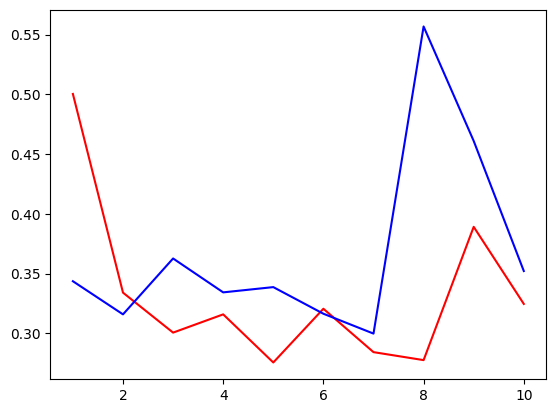

In [11]:
import matplotlib.pyplot as plt

plt.plot([*range(1,epochs+1)], train_list, color="red")
plt.plot([*range(1,epochs+1)], validation_list, color="blue")
#plt.ylim(0,1)
